In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/AmitCohen3/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 721.3 kB/s eta 0:00:000:00:01
  Cloning https://github.com/AmitCohen3/CLIP.git to /private/var/folders/lf/66j3dx5j6nd9nf35vrgw_qlc0000gn/T/pip-req-build-h4dspku0
  Running command git clone --filter=blob:none --quiet https://github.com/AmitCohen3/CLIP.git /private/var/folders/lf/66j3dx5j6nd9nf35vrgw_qlc0000gn/T/pip-req-build-h4dspku0
  Resolved https://github.com/AmitCohen3/CLIP.git to commit 1d7bdb3407643fb088fddf4c08c165c731a35289
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=799ca2d1404137aebfbe6431c6b61e57cc1b7aa5afa0f09f4921b37c51de1221
  Stored in directory: /private/var/folders/lf/66j3dx5j6nd9nf35vrgw_qlc0000gn/T/pip-ephem-wheel-cache-4fkls14b/wheels/1e/99/66/0a985f92fe1a3e84584130443486574c93145cd1b4b410eab6
Successfully built clip


In [140]:
# !wget -O "cat.png" "https://drive.google.com/uc?export=download&id=1ONDKkjoUVZwOUd7SzvfcDMqWOdVLyvuG"
import requests

url = "https://drive.google.com/uc?export=download&id=1ONDKkjoUVZwOUd7SzvfcDMqWOdVLyvuG"
response = requests.get(url)

with open("cat.png", "wb") as file:
    file.write(response.content)
image_path = "cat.png"

In [141]:
import torch
import clip
from PIL import Image

In [149]:
class Attack:
    
    def __init__(self, model, embeddings, step_size, att_sen_max_len, num_of_iters):
        self.model = model
        self.embeddings = embeddings
        self.step_size = step_size
        self.att_sen_max_len = att_sen_max_len
        self.num_of_iters = num_of_iters
        self.tokenizer = clip.simple_tokenizer.SimpleTokenizer()

    def decode_sentences(self, embedded_attacking_text):
        embeddings_normed = self.embeddings / self.embeddings.norm(dim=1, keepdim=True)
        embeddings_normed = embeddings_normed.float()
        embedded_attacking_text_normed = embedded_attacking_text / embedded_attacking_text.norm(dim=2, keepdim=True)
        embedded_attacking_text_normed = embedded_attacking_text_normed.float()
        # Calculate the cosine similarity between the attacking text and the embeddings
        score = torch.matmul(embedded_attacking_text_normed.permute(1, 0, 2), embeddings_normed.T)
        # For each attacking embedding, find the index of the most similar embedding
        ids = score.argmax(dim=2)
        return ids
    

    def apply(self, image, ref_text=None):
        centroid = torch.mean(embeddings, dim=0)
        attacking_text = clip.tokenize([" ".join(["BLANK"] * i) for i in range (3, self.att_sen_max_len)]).to(device)
        with torch.no_grad():
            embedded_attacking_text = self.model.embed_text(attacking_text)
            image_features = self.model.encode_image(image)
            if ref_text is not None:
                reference_text = clip.tokenize(ref_text).to(device)
                ref_features = model.encode_text(reference_text)
        
        eot_indices=attacking_text.argmax(dim=-1)
        for j, eot in enumerate (eot_indices):
            embedded_attacking_text[1:eot, j, :] = centroid
        
        best_logit = -float("inf")
        best_sentence = attacking_text
    
        for i in range (self.num_of_iters):
            embedded_attacking_text = embedded_attacking_text.requires_grad_()
            model.zero_grad()
            attacking_text_features = model.encode_embeddings(embedded_attacking_text, eot_indices)
            cost = (attacking_text_features/attacking_text_features.norm(dim=-1, keepdim=True)) @ (image_features.T/image_features.norm(dim=-1, keepdim=True))
            if ref_features is not None:
                cost = cost -0.5 * (attacking_text_features/attacking_text_features.norm(dim=-1, keepdim=True)) @ (ref_features.T/ref_features.norm(dim=-1, keepdim=True))
            cost = cost.sum()
            cost.backward()
            # Attack step
            adv = embedded_attacking_text + self.step_size*embedded_attacking_text.grad.sign()
            embedded_attacking_text = adv.detach_()
            # Decode
            decoded_sentences = self.decode_sentences(embedded_attacking_text)
            with torch.no_grad():
                embedded_text_after_decoding = self.model.embed_text(decoded_sentences)
                logits, _ = self.model(image, embedded_text_after_decoding, eot_indices=decoded_sentences.argmax(dim=-1))
                if torch.max(logits) > best_logit:
                    best_logit = torch.max(logits)
                    best_sentence = decoded_sentences[torch.argmax(logits)].view(1,-1)
    
        decoded_text = self.tokenizer.decode(best_sentence.squeeze(0).tolist()[1:best_sentence.argmax(dim=-1)])
        return decoded_text

In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
embeddings = model.token_embedding.weight.data
num_of_iters = 50
attacking_sentence_max_len = 20
step_size = 0.001
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
reference_text = "an image of a cat"

# Initialize the attack
attack = Attack(model, embeddings, step_size, attacking_sentence_max_len, num_of_iters)
# Perform the attack and get the attacking text
attacking_text = attack.apply(image, reference_text)

other_texts = ["a cat on a mat", "white cat"]
tokenized_texts = clip.tokenize([attacking_text, reference_text]+other_texts).to(device)
logits, _ = model(image, model.embed_text(tokenized_texts), eot_indices=tokenized_texts.argmax(dim=-1))
probs = logits.softmax(dim=-1).detach().cpu().numpy()

print("Attacking text:", attacking_text)
print("Attacking text probability:", probs[0][0])
print("Reference text probability:", probs[0][1])
print("Other text probabilities:", probs[0][2:])


Attacking text: dreambig curled rescue
Attacking text probability: 0.5793228
Reference text probability: 0.14478666
Other text probabilities: [0.21812879 0.05776178]


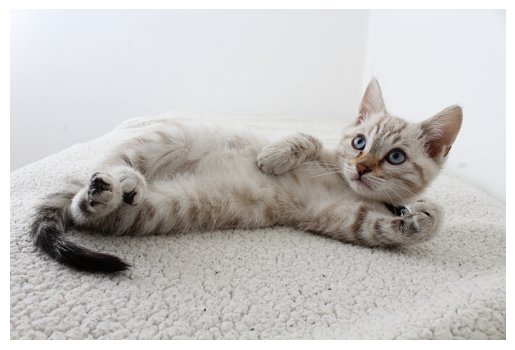

In [134]:
# show image and text
import matplotlib.pyplot as plt
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

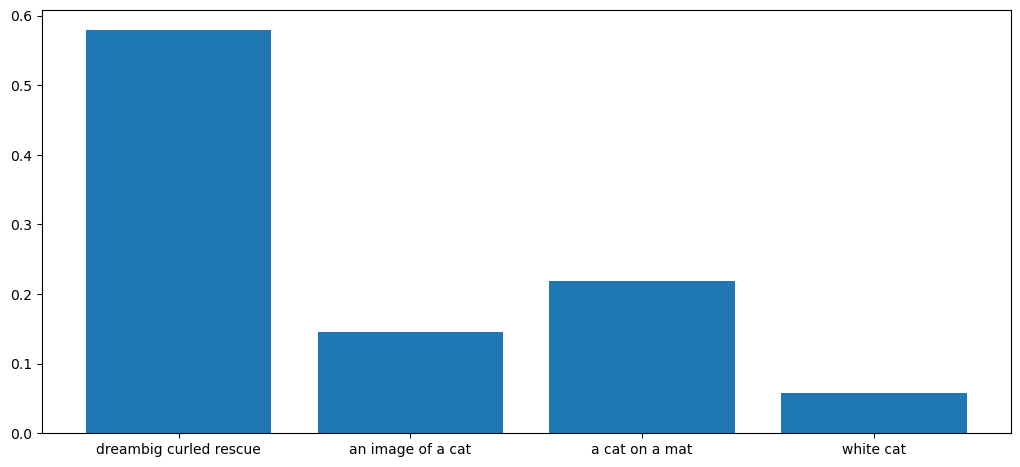

In [135]:
#plot histogram of plot as y and [attacking_text, reference_text, "a cat on a mat", "white cat"] as x
import numpy as np
import matplotlib.pyplot as plt
plt.bar([attacking_text, reference_text]+other_texts, probs[0])
#make it wider to see the text
fig = plt.gcf()
fig.set_size_inches(12.5, 5.5)

plt.show()